In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import dill # Load the model
import statsmodels.api as sm
from pygam import PoissonGAM, s, f, te

%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

In [3]:
# load the model
with open('gradientboosting.pkl', 'rb') as file:
    model = dill.load(file) 

In [4]:
class subset_helper():
    def __init__(self, data):
        self.data = data
        
    def get_summer(self, df):
        return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]

    def get_disease(self, df):
        diseases = ('Diseases of the circulatory system', 
                    'Diseases of the respiratory system', 
                    'Diseases of the skin and subcutaneous tissue')
        return df[df['COD'].isin(diseases)]
    
    def subset(self):
        self.data = self.get_summer(self.data)
        self.data = self.get_disease(self.data)
        return self.data
mortality = subset_helper(mortality).subset()

In [5]:
# Train-test split
TEST_SIZE = 0.1
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop(['COUNT'], axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [6]:
# Predicted output from the black box model
y_pred = model.predict(X_train)
X_train_gam = model.named_steps['preprocessing'].transform(X_train)

In [7]:
# Initializationmodel
np.random.seed(SEED)
lams = np.exp(np.random.random((50, 18)) * 6 - 3)

In [8]:
# Surrogate
surrogate = PoissonGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + 
                      s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + te(5, 0))
surrogate.gridsearch(X_train_gam, y_pred, lam = lams)

100% (50 of 50) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


PoissonGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + te(5, 0) + intercept,
   tol=0.0001, verbose=False)

In [9]:
# Modle summary
surrogate.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     95.8481
Link Function:                          LogLink Log Likelihood:                                 -9784.4891
Number of Samples:                         2246 AIC:                                            19760.6743
                                                AICc:                                           19769.4972
                                                UBRE:                                                6.292
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9472
Feature Function                  Lam

<ipython-input-9-824c98e15777>:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  surrogate.summary()


In [10]:
# Get feature names from the pipeline obj
def get_feature_names(model):
    cont_name = model.named_steps['preprocessing'].transformers_[1][2]
    cat_name = model.named_steps['preprocessing'].transformers_[2][1].get_feature_names().tolist()
    return cont_name + cat_name

<Figure size 432x288 with 0 Axes>

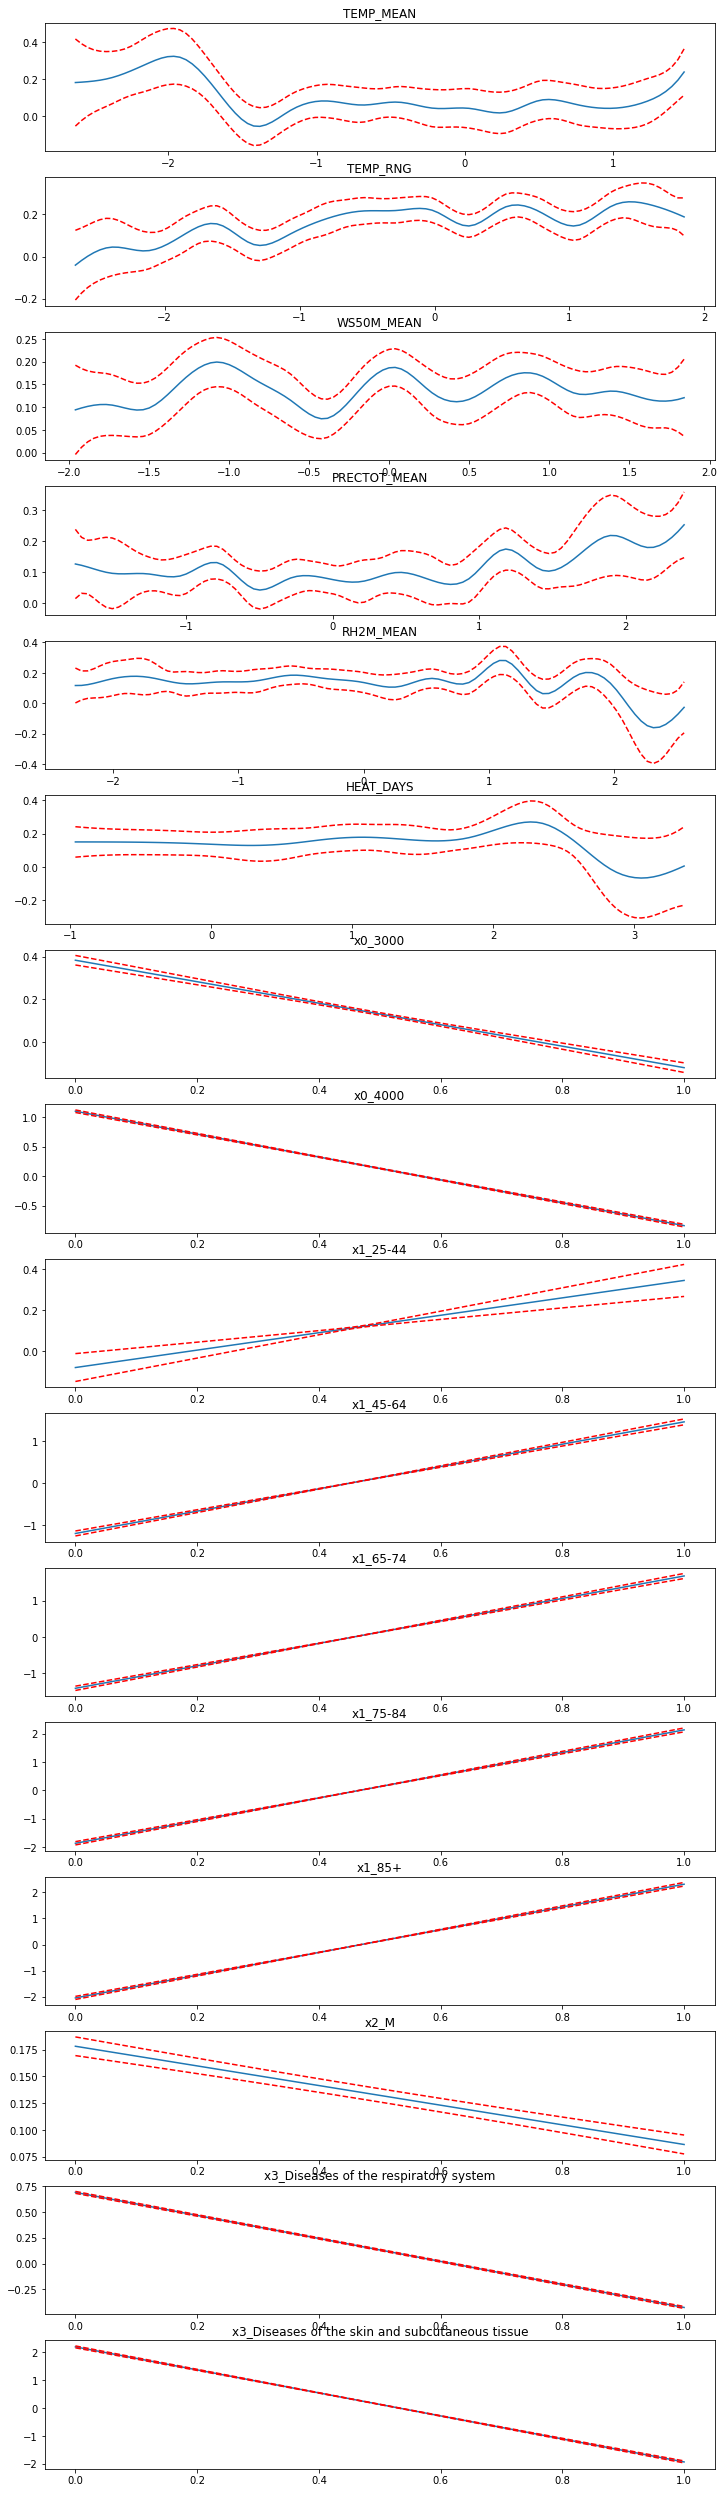

In [11]:
# Partial dependence plot
titles = get_feature_names(model) + ['TEMP_MEAN X HEAT_DAYS']
plt.figure()
fig, axs = plt.subplots(16, 1, figsize = (12, 45)) 
for i, ax in enumerate(axs):
    XX = surrogate.generate_X_grid(term = i)
    ax.plot(XX[:, i], surrogate.partial_dependence(term = i, X = XX))
    ax.plot(XX[:, i], surrogate.partial_dependence(term = i, X = XX,   width=.95)[1], 
            c = 'r', ls = '--')
    ax.set_title(titles[i])

In [12]:
y_pred_test = model.predict(X_train)
y_pred_gam = surrogate.predict(model.named_steps['preprocessing'].transform(X_train))
mean_squared_error(y_pred_test, y_pred_gam)

534.268771366499

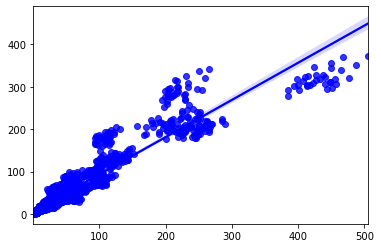

In [13]:
# Training data
sns.regplot(x = y_pred_test, y = y_pred_gam, color = 'blue')